In [15]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso


def load_data(csv_path):
    """
    Reads a CSV file (train or test) and returns the data contained.

    Parameters
    ----------
    csv_path : String
        Path to the CSV file to be read.
        e.g., "train.csv"

    Returns
    -------
    data : Pandas DataFrame 
        Data read from CSV file.
    n_samples : Integer
        Number of rows (samples) in the dataset.
    """
    data = pd.read_csv(csv_path, index_col="TRIP_ID")

    return data, len(data)
def write_submission(trip_ids, destinations, file_name="submission"):
    """
    This function writes a submission csv file given the trip ids, 
    and the predicted destinations.

    Parameters
    ----------
    trip_id : List of Strings
        List of trip ids (e.g., "T1").
    destinations : NumPy Array of Shape (n_samples, 2) with float values
        Array of destinations (latitude and longitude) for each trip.
    file_name : String
        Name of the submission file to be saved.
        Default: "submission".
    """
    n_samples = len(trip_ids)
    assert destinations.shape == (n_samples, 2)

    submission = pd.DataFrame(
        data={
            'LATITUDE': destinations[:, 0],
            'LONGITUDE': destinations[:, 1],
        },
        columns=["LATITUDE", "LONGITUDE"],
        index=trip_ids,
    )

    # Write file
    submission.to_csv(file_name + ".csv", index_label="TRIP_ID")
def haversine(pred, gt):
    """
    Havarsine distance between two points on the Earth surface.

    Parameters
    -----
    pred: numpy array of shape (N, 2)
        Contains predicted (LATITUDE, LONGITUDE).
    gt: numpy array of shape (N, 2)
        Contains ground-truth (LATITUDE, LONGITUDE).

    Returns
    ------
    numpy array of shape (N,)
        Contains haversine distance between predictions
        and ground truth.
    """
    pred_lat = np.radians(pred[:, 0])
    pred_long = np.radians(pred[:, 1])
    gt_lat = np.radians(gt[:, 0])
    gt_long = np.radians(gt[:, 1])

    dlat = gt_lat - pred_lat
    dlon = gt_long - pred_long

    a = np.sin(dlat/2)**2 + np.cos(pred_lat) * np.cos(gt_lat) * np.sin(dlon/2)**2

    d = 2 * 6371 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    return d


In [16]:

train_data, n_trip_train = load_data("train.csv")
test_data, n_trip_test = load_data("test.csv")

In [17]:
def preprocess(data):
    # Remove the trips without any information 
    data = data[data['POLYLINE'] != '[]']
    
    # Remove the trips with missing information ???(Il existe juste 10 avec la valeur True)
    data = data[data['MISSING_DATA'] == False]
    data = data[:100000]
    data = data.drop('DAY_TYPE', axis=1)
    data = data[~data.index.duplicated(keep='first')]
    # Taking not the all data to reduce the time of training
    #Extracting the point
    #Setting the starting point and the ending point of the trip
    data['START_Long'] = [eval(polyline)[0][0] for polyline in data['POLYLINE']]
    data['START_Lat'] = [eval(polyline)[0][1] for polyline in data['POLYLINE']]
    data['END_Long'] = [eval(polyline)[-1][0] for polyline in data['POLYLINE']]
    data['END_Lat'] = [eval(polyline)[-1][1] for polyline in data['POLYLINE']]
    # Replace the type of the day and the call
    data['CALL_TYPE'] = data['CALL_TYPE'].replace(['A', 'B', 'C'], [0, 1, 2])
    # Replace the Nan into 0 in the features
    data = data.fillna(0)
    data = data.drop('POLYLINE', axis=1)
    data['WEEKDAY'] = [date.weekday() for date in pd.to_datetime(data['TIMESTAMP'], unit='s')]
    data['HOUR'] = [date.hour for date in pd.to_datetime(data['TIMESTAMP'], unit='s')]
    data = data.drop('TIMESTAMP', axis=1)


    X, y = data.drop(['END_Long', 'END_Lat'], axis=1), data[['END_Long', 'END_Lat']]
    return X, y

X_train, y_train = preprocess(train_data)
X_test, y_test = preprocess(test_data)
y_test = np.stack((y_test['END_Lat'],y_test['END_Long']), axis=-1)

The mean of the best max_depth is: 9 with the value of : 3.669224128656854


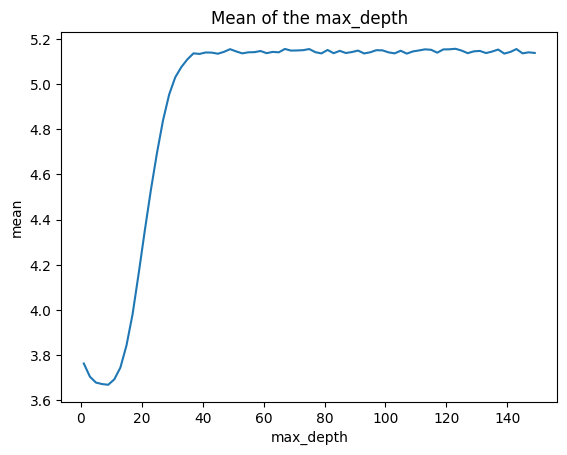

In [4]:
#using decision tree and Finding the best max_depth
def FindBestDT(max_depth,random_state_t,fold,x,y):
    kf = KFold(n_splits=fold,random_state= random_state_t, shuffle=True)
    mean_array = []
    std_array = []

    for i in range(len(max_depth)):
        fold_mean = []
        fold_std = []
        for j, (train_index, test_index) in enumerate(kf.split(x)):
            X_train, y_train = x[train_index], y[train_index]
            X_test, y_test = x[test_index], y[test_index]
            clf = DecisionTreeRegressor(random_state=i, max_depth=max_depth[i]).fit(X_train, y_train)
            y_pred =clf.predict(X_test)
            y_pred = np.stack((y_pred[:,0],y_pred[:,1]), axis=-1)
            y_test = np.stack((y_test[:,0],y_test[:,1]), axis=-1)
            data = haversine(y_pred, y_test)
            fold_mean.append(data.mean())
            fold_std.append(data.std())
        mean_array.append(np.mean(fold_mean))
        std_array.append(np.mean(fold_std))
    Min_mean = min(mean_array)
    print("The mean of the best max_depth is:", mean_array.index(Min_mean)*2+1,"with the value of :",Min_mean)
    plt.figure()
    plt.plot(max_depth,mean_array)
    plt.xlabel('max_depth')
    plt.ylabel('mean')
    plt.title('Mean of the max_depth')
    plt.show()
        
max_depth = [i for i in range(1,150,2)]
FindBestDT(max_depth,0,10,X_train.values,y_train.values)


The mean of the best k is: 101 with the value of: 3.792427024636434


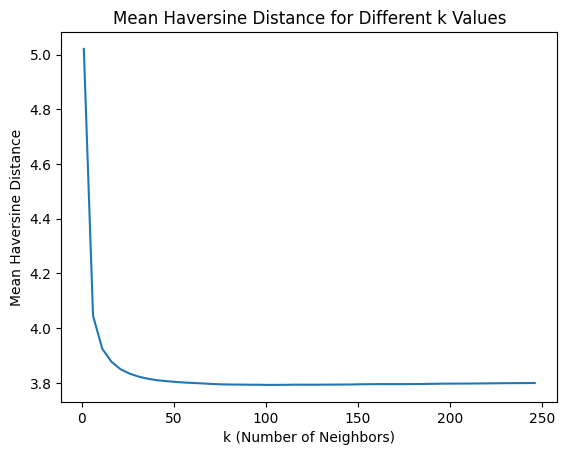

In [5]:


def FindBestKNN(n_neighbors, random_state_t, fold, x, y):
    kf = KFold(n_splits=fold, random_state=random_state_t, shuffle=True)
    mean_array = []
    std_array = []
    for i in range(len(n_neighbors)):
        fold_mean = []
        fold_std = []
        for j, (train_index, test_index) in enumerate(kf.split(x)):
            X_train, y_train = x[train_index], y[train_index]
            X_test, y_test = x[test_index], y[test_index]
            clf = KNeighborsRegressor(n_neighbors=n_neighbors[i]).fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_pred = np.stack((y_pred[:, 0], y_pred[:, 1]), axis=-1)
            y_test = np.stack((y_test[:, 0], y_test[:, 1]), axis=-1)
            data = haversine(y_pred, y_test)
            fold_mean.append(data.mean())
            fold_std.append(data.std())
        mean_array.append(np.mean(fold_mean))
        std_array.append(np.mean(fold_std))
    Min_mean = min(mean_array)
    print("The mean of the best k is:", mean_array.index(Min_mean)*5+1, "with the value of:", Min_mean)
    plt.figure()
    plt.plot(k_values, mean_array)
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Mean Haversine Distance')
    plt.title('Mean Haversine Distance for Different k Values')
    plt.show()

# Example usage:
k_values = [i for i in range(1, 250,5)]
FindBestKNN(k_values, 0, 10, X_train.values, y_train.values)

The mean of the best k is: (20, 20) with the value of: 3.8267536822549983


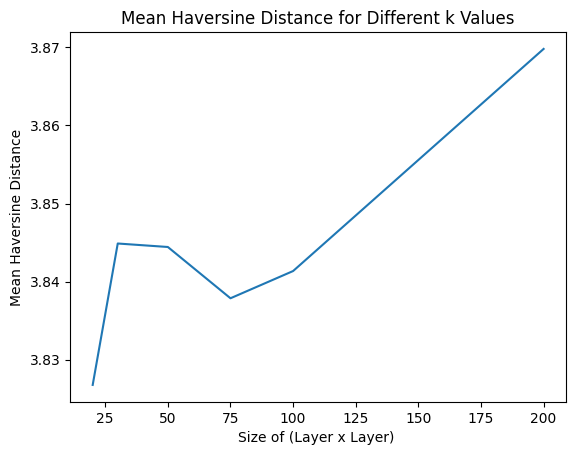

In [6]:
from sklearn.neural_network import MLPRegressor
def FindLayer(n_neighbors, random_state_t, fold, x, y):
    kf = KFold(n_splits=fold, random_state=random_state_t, shuffle=True)
    mean_array = []
    std_array = []
    for i in range(len(n_neighbors)):
        fold_mean = []
        fold_std = []
        for j, (train_index, test_index) in enumerate(kf.split(x)):
            X_train, y_train = x[train_index], y[train_index]
            X_test, y_test = x[test_index], y[test_index]
            clf = MLPRegressor(hidden_layer_sizes=n_neighbors[i], max_iter=5000, activation="logistic").fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_pred = np.stack((y_pred[:, 0], y_pred[:, 1]), axis=-1)
            y_test = np.stack((y_test[:, 0], y_test[:, 1]), axis=-1)
            data = haversine(y_pred, y_test)
            fold_mean.append(data.mean())
            fold_std.append(data.std())
        mean_array.append(np.mean(fold_mean))
        std_array.append(np.mean(fold_std))
    Min_mean = min(mean_array)
    print("The mean of the best k is:",  n_neighbors[mean_array.index(Min_mean)], "with the value of:", Min_mean)
    plt.figure()
    k_values = [20,30,50,75,100,200,300,400,500]
    plt.plot(k_values, mean_array)
    plt.xlabel('Size of (Layer x Layer) ')
    plt.ylabel('Mean Haversine Distance')
    plt.title('Mean Haversine Distance for Different k Values')
    plt.show()

# Example usage:
s = [(20,20),(30,30), (50,50),(75,75), (100,100), (200,200),(300,300),(400,400),(500,500)]
FindLayer(s, 0, 10, X_train.values, y_train.values)


In [7]:
def write_submission(trip_ids, destinations, file_name="submission"):
    """
    This function writes a submission csv file given the trip ids, 
    and the predicted destinations.

    Parameters
    ----------
    trip_id : List of Strings
        List of trip ids (e.g., "T1").
    destinations : NumPy Array of Shape (n_samples, 2) with float values
        Array of destinations (latitude and longitude) for each trip.
    file_name : String
        Name of the submission file to be saved.
        Default: "submission".
    """
    n_samples = len(trip_ids)
    assert destinations.shape == (n_samples, 2)

    submission = pd.DataFrame(
        data={
            'LATITUDE': destinations[:, 0],
            'LONGITUDE': destinations[:, 1],
        },
        columns=["LATITUDE", "LONGITUDE"],
        index=trip_ids,
    )

    # Write file
    submission.to_csv(file_name + ".csv", index_label="TRIP_ID")
test_trips_ids = list(test_data.index)
destinations = np.stack((y_test[:,0],y_test[:,1]), axis=-1)
write_submission(
        trip_ids=test_trips_ids, 
        destinations=destinations,
        file_name="example_submission"
    )

The mean of the best k is: 2.502404809619239 with the value of: 3.6719807475527846


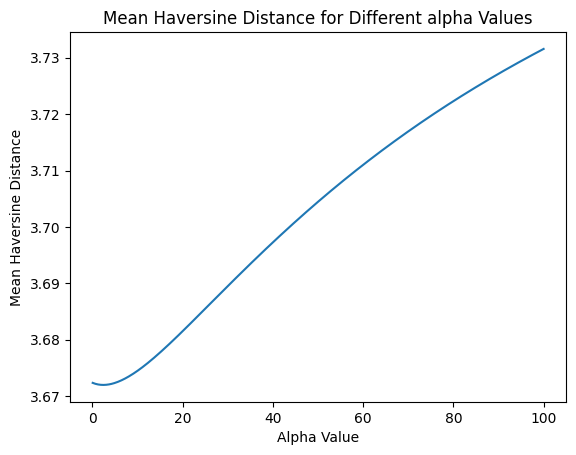

In [8]:
def FindAlpha(n_neighbors, random_state_t, fold, x, y):
    kf = KFold(n_splits=fold, random_state=random_state_t, shuffle=True)
    mean_array = []
    std_array = []
    for i in range(len(n_neighbors)):
        fold_mean = []
        fold_std = []
        for j, (train_index, test_index) in enumerate(kf.split(x)):
            X_train, y_train = x[train_index], y[train_index]
            X_test, y_test = x[test_index], y[test_index]
            clf = Ridge(alpha=n_neighbors[i]).fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_pred = np.stack((y_pred[:, 0], y_pred[:, 1]), axis=-1)
            y_test = np.stack((y_test[:, 0], y_test[:, 1]), axis=-1)
            data = haversine(y_pred, y_test)
            fold_mean.append(data.mean())
            fold_std.append(data.std())
        mean_array.append(np.mean(fold_mean))
        std_array.append(np.mean(fold_std))
    Min_mean = min(mean_array)
    print("The mean of the best k is:", n_neighbors[mean_array.index(Min_mean)], "with the value of:", Min_mean)
    plt.figure()
    plt.plot(n_neighbors, mean_array)
    plt.xlabel('Alpha Value')
    plt.ylabel('Mean Haversine Distance')
    plt.title('Mean Haversine Distance for Different alpha Values')
    plt.show()

# Example usage:
s = np.linspace(0.1,100,500)
FindAlpha(s, 0, 10, X_train.values, y_train.values)

The mean of the best k is: 2.502404809619239 with the value of: 3.8243899949630284


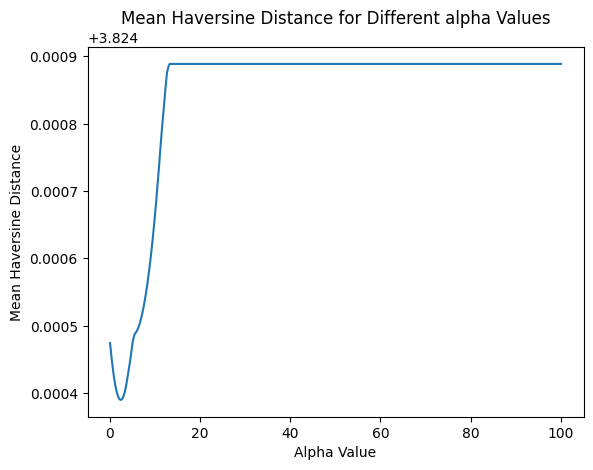

In [9]:
def FindLasso(n_neighbors, random_state_t, fold, x, y):
    kf = KFold(n_splits=fold, random_state=random_state_t, shuffle=True)
    mean_array = []
    std_array = []
    for i in range(len(n_neighbors)):
        fold_mean = []
        fold_std = []
        for j, (train_index, test_index) in enumerate(kf.split(x)):
            X_train, y_train = x[train_index], y[train_index]
            X_test, y_test = x[test_index], y[test_index]
            clf = Lasso(alpha=n_neighbors[i]).fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_pred = np.stack((y_pred[:, 0], y_pred[:, 1]), axis=-1)
            y_test = np.stack((y_test[:, 0], y_test[:, 1]), axis=-1)
            data = haversine(y_pred, y_test)
            fold_mean.append(data.mean())
            fold_std.append(data.std())
        mean_array.append(np.mean(fold_mean))
        std_array.append(np.mean(fold_std))
    Min_mean = min(mean_array)
    print("The mean of the best k is:",  n_neighbors[mean_array.index(Min_mean)], "with the value of:", Min_mean)
    plt.figure()
    plt.plot(n_neighbors, mean_array)
    plt.xlabel('Alpha Value')
    plt.ylabel('Mean Haversine Distance')
    plt.title('Mean Haversine Distance for Different alpha Values')
    plt.show()

# Example usage:
s = np.linspace(0.1,100,500)
FindLasso(s, 0, 10, X_train.values, y_train.values)

In [20]:
model_1 = DecisionTreeRegressor(max_depth=9, random_state=0)
model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)
y_pred_1 = np.stack((y_pred_1[:, 1], y_pred_1[:, 0]), axis=-1)
write_submission(
        trip_ids=test_trips_ids, 
        destinations=y_pred_1,
        file_name="submission_DT"
    )

#Using Ridge
model_3 = Ridge(alpha = 2.5)
model_3.fit(X_train, y_train)
y_pred_3 = model_3.predict(X_test)
y_pred_3 = np.stack((y_pred_3[:, 1], y_pred_3[:, 0]), axis=-1)
write_submission(
        trip_ids=test_trips_ids, 
        destinations=y_pred_3,
        file_name="submission_Ridge"
    )

#Using Lasso
model_4 = Lasso(alpha=2.5)
model_4.fit(X_train, y_train)
y_pred_4 = model_4.predict(X_test)
y_pred_4 = np.stack((y_pred_4[:, 1], y_pred_4[:, 0]), axis=-1)
write_submission(
        trip_ids=test_trips_ids, 
        destinations=y_pred_4,
        file_name="submission_Lasso"
    )

#Using MLP
model_5 = MLPRegressor(hidden_layer_sizes=(30, 30), max_iter=5000,activation= "logistic")
model_5.fit(X_train, y_train)
y_pred_5 = model_5.predict(X_test)
y_pred_5 = np.stack((y_pred_5[:, 1], y_pred_5[:, 0]), axis=-1)
write_submission(
        trip_ids=test_trips_ids, 
        destinations=y_pred_5,
        file_name="submission_MLP"
    )

In [21]:
from sklearn.neural_network import MLPRegressor
X_Data_train,X_Data_test,y_Data_train,y_Data_test = train_test_split(X_train, y_train, test_size=0.1, random_state=0)



y_Data_test = np.stack((y_Data_test['END_Lat'],y_Data_test['END_Long']), axis=-1)
#Using DecisionTree
model_1 = DecisionTreeRegressor(max_depth=9, random_state=0)
model_1.fit(X_Data_train, y_Data_train)
y_pred_1 = model_1.predict(X_Data_test)

#Using KNN
model_2 = KNeighborsRegressor(n_neighbors=66)
model_2.fit(X_Data_train, y_Data_train)
y_pred_2 = model_2.predict(X_Data_test)

#Using Ridge
model_3 = Ridge(alpha = 2.5)
model_3.fit(X_Data_train, y_Data_train)
y_pred_3 = model_3.predict(X_Data_test)

#Using Lasso
model_4 = Lasso(alpha=2.5)
model_4.fit(X_Data_train, y_Data_train)
y_pred_4 = model_4.predict(X_Data_test)

#Using MLP
model_5 = MLPRegressor(hidden_layer_sizes=(30, 30), max_iter=5000,activation= "logistic")
model_5.fit(X_Data_train, y_Data_train)
y_pred_5 = model_5.predict(X_Data_test)

Output = np.concatenate([y_pred_1, y_pred_2, y_pred_3, y_pred_4,y_pred_5], axis=1)

#Using the meta model to train the data and predict using again RandomForest
Meta_data = np.concatenate([Output,X_Data_test], axis=1)
Meta_model = RandomForestRegressor()
Meta_model.fit(Meta_data, y_Data_test)

#Using the meta model to predict the test data
Output2 = Output[:320]
New_X_test = np.concatenate([Output2, X_test], axis=1)
destinations=Meta_model.predict(New_X_test)

print("Stacking", haversine(destinations, y_test).mean(), haversine(destinations, y_test).std())
write_submission(
        trip_ids=test_trips_ids, 
        destinations=destinations,
        file_name="submission_Stacking"
    )


Stacking 3.767235903609034 5.953594818475278
